Training a prediction model using Pytorch Deep Learning
=======================================
**Author:** `Grej Segura`


In [23]:
from torch import nn, optim
from torch.autograd import Variable
import torch
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
import os
import gc

import matplotlib.pyplot as plt
%matplotlib inline

## clear GPU memory to optimize capacity
torch.cuda.empty_cache()

In [24]:
os.chdir(r'C:\Users\User\Documents\Data_Science_Projects\santander-customer-prediction')

# load the cleanData
# load the cleanData
data = pd.read_csv(r'.\data\trainFinal.csv')

In [25]:
data = data.sample(frac=0.5, replace=False, random_state=1)

In [26]:
# set the device to GPU if Gpu exists else use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### Creating train and test dataset

In [27]:
def preprocess_data(data):
    data = data.rename(columns={'target': 'labels'})
    summary = data.describe().transpose()
    cols = data[summary[summary['max']>1].reset_index()['index'].tolist()].columns[1:]

    # separate the labels/target variable
    dataX = data.drop(['labels'], axis = 1)
    dataY = data['labels']

    # Create train and test dataset
    X_train, x_test, Y_train, y_test = train_test_split(dataX, dataY, stratify=dataY)

    gather_data = pd.DataFrame(columns = ['feature', 'mean', 'std'])
#    for i in cols:
#        ave = X_train[i].mean()
#        std = X_train[i].std()
#        appended = pd.DataFrame({'feature': i, 'mean': ave, 'std': std}, index = [0])
#        gather_data = gather_data.append(appended, ignore_index=True)
#        x_test[i] = (x_test[i]-ave)/std
#        X_train[i] = (X_train[i]-ave)/std

    # First, scale the Data - only those numerical/non-categorical
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return X_train, x_test, Y_train, y_test, #gather_data

X_train, x_test, Y_train, y_test = preprocess_data(data)
#gather_data.to_csv(r'.\data\output\mean_std_scaler.csv', index=False)



In [29]:
#gather_data.to_csv(r'.\data\output\mean_std_scaler.csv', index=False)
n_columns = len(data.columns)
del data
gc.collect()


207

#### Convert the data to tensor and load to cuda memory

In [30]:
def convert_to_tensor(X, Y, x_test, y_test):
    # making sure the training will use gpu
    torch.cuda.set_device(0)
    torch.backends.cudnn.benchmark=True

    # convert all dataset to cuda tensor to be able to use the GPU
    dtype = torch.cuda.FloatTensor
    X = np.array(X)
    x_test = np.array(x_test)
    Y = np.array(Y)
    y_test = np.array(y_test)
    X_train = torch.tensor(X, device=device).type(dtype)
    x_test = torch.tensor(x_test, device=device).type(dtype)


    Y_train = torch.tensor(Y, device=device).type(dtype)
    y_test = torch.tensor(y_test, device=device).type(dtype)

    Y_train = torch.unsqueeze(Y_train, 1)
    y_test = torch.unsqueeze(y_test, 1)
    return X_train, x_test, Y_train, y_test

X_train, x_test, Y_train, y_test = convert_to_tensor(X_train, Y_train, x_test, y_test)

In [31]:
print(len(Y_train[Y_train==1]))
print(len(Y_train[Y_train==0]))

7478
67522


#### Creating the model and training

In [33]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(n_columns-1, 533)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
                
        self.fc2 = nn.Linear(533, 355)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(355, 236)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(236, 157)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)                             
        
        self.fc5 = nn.Linear(157, 100)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
        
        self.fc6 = nn.Linear(100, 70)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
                             
        self.fc7 = nn.Linear(70, 45)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)
                             
        self.fc8 = nn.Linear(45, 30)
        self.prelu = nn.PReLU(1)
        self.dout = nn.Dropout(0.2)

        self.fc9 = nn.Linear(30, 10)
        self.prelu = nn.PReLU(1)
                             
        self.out = nn.Linear(10, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        dout = self.dout(h2)
        
        a3 = self.fc3(dout)
        h3 = self.prelu(a3)
        dout = self.dout(h3)
        
        a4 = self.fc4(dout)
        h4 = self.prelu(a4)
        dout = self.dout(h4)
        
        a5 = self.fc5(dout)
        h5 = self.prelu(a5)
        dout = self.dout(h5)
        
        a6 = self.fc6(dout)
        h6 = self.prelu(a6)
        dout = self.dout(h6)

        a7 = self.fc7(dout)
        h7 = self.prelu(a7)
        dout = self.dout(h7)
                             
        a8 = self.fc8(dout)
        h8 = self.prelu(a8)
        dout = self.dout(h8)
                             
        a9 = self.fc9(dout)
        h8 = self.prelu(a9)
                             
        a10 = self.out(h8)
        
        y = self.out_act(a10)
        return y

In [34]:
model = Classifier().cuda()
criterion = nn.BCELoss() ## loss function for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.003) ## adam optimizer

In [35]:
## clear GPU memory to optimize capacity
torch.cuda.empty_cache()
gc.collect()

60

epoch 0, loss 0.6470701098442078
epoch 50, loss 0.2638011574745178
epoch 100, loss 0.2452404648065567
epoch 150, loss 0.2537733316421509
epoch 200, loss 0.2594269812107086
epoch 250, loss 0.25835567712783813
epoch 300, loss 0.23210325837135315
epoch 350, loss 0.27951186895370483
epoch 400, loss 0.25674450397491455
epoch 450, loss 0.23541724681854248
epoch 500, loss 0.22589921951293945
epoch 550, loss 0.23208153247833252
epoch 600, loss 0.22845427691936493
epoch 650, loss 0.22770893573760986
epoch 700, loss 0.22971414029598236
epoch 750, loss 0.22369801998138428
epoch 800, loss 0.22455234825611115
epoch 850, loss 0.23314206302165985
epoch 900, loss 0.22385695576667786
epoch 950, loss 0.22227588295936584
epoch 1000, loss 0.22692681849002838
epoch 1050, loss 0.22560130059719086
epoch 1100, loss 0.22276583313941956
epoch 1150, loss 0.22468259930610657
epoch 1200, loss 0.22288239002227783
epoch 1250, loss 0.2244146317243576
epoch 1300, loss 0.23475797474384308
epoch 1350, loss 0.23003582656

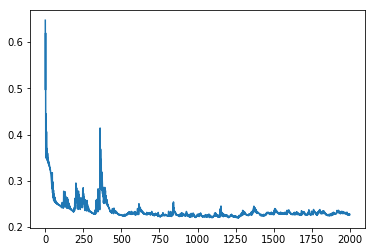

In [36]:
n_epochs = 2000
e_losses = []

for epoch in range(n_epochs):
    
    # forward pass
    outputs = model.forward(X_train)

    # calculate loss (MSE)
    loss = criterion(outputs, Y_train)
    e_losses.append(loss.data.detach())

    # compute gradients
    loss.backward()
    
    # perform one step in the oposite direction to the gradient (update weights)
    optimizer.step()
    
    # clear gradient values after weights are updated
    optimizer.zero_grad()
    torch.cuda.empty_cache()
    if epoch % 50 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))
plt.plot(e_losses)

In [37]:
def predict_new_data(x_test, y_test, model):
    # switch to evaluation mode
    model = model.eval()

    with torch.no_grad():
        y_pred = model.forward(x_test).cpu().numpy()

    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(int)
    y_test = y_test.cpu().numpy()
    accuracy = metrics.accuracy_score(y_pred, y_test).astype(str)
    print('\n\naccuracy is ' + accuracy)

    precision = metrics.precision_score(y_test, y_pred).astype(str)
    print('precision is ' + precision)
    recall = metrics.recall_score(y_test, y_pred).astype(str)
    print('recall is ' + recall)
    auc = metrics.roc_auc_score(np.asarray(y_test), y_pred).astype(str)
    print('auc is ' + auc)

    f1 = 2*((precision.astype(np.float64)*recall.astype(np.float64))/(precision.astype(np.float64)+recall.astype(np.float64)))
    print('f1-score is ' + f1.astype(str))
    
    return y_pred

y_pred_train = predict_new_data(X_train, Y_train, model)
y_pred_test = predict_new_data(x_test, y_test, model)



accuracy is 0.9322666666666667
precision is 0.8258152173913044
recall is 0.40639208344477135
auc is 0.6984494406145986
f1-score is 0.5447212762143754


accuracy is 0.90604
precision is 0.5634920634920635
recall is 0.2563176895306859
auc is 0.617162265923205
f1-score is 0.3523573200992555


In [38]:
## save the model
torch.save(model.state_dict(), r'.\models\pytorch_model.pt')

In [39]:
## clear GPU memory to optimize capacity
torch.cuda.empty_cache()
del X_train, Y_train, x_test, y_test
gc.collect()

0

In [ ]:
'''accuracy is 0.9198761904761905
precision is 0.7797716150081566
recall is 0.27389934103715025
auc is 0.6326652710221242
f1-score is 0.4053996748886848


accuracy is 0.9119428571428572
precision is 0.6574074074074074
recall is 0.24412607449856732
auc is 0.6150176548310038
f1-score is 0.3560384454659423'''